# Fashion-MNIST Transfer Learning Project

This project demonstrates the complete workflow of applying transfer learning using pre-trained deep learning models (MobileNetV2 and ResNet50) on the Fashion-MNIST dataset.

## Project Overview

**Transfer Learning** is a machine learning technique that leverages models pre-trained on large datasets to solve new, related tasks. In this project, we utilize models pre-trained on ImageNet to classify Fashion-MNIST clothing images.

**Key Advantages:**
- Reduced training time
- Requires less training data
- Often achieves better performance
- Lower computational resource requirements

# Configuration Management and Environment Setup

First, we establish all hyperparameters and configurations for our experiment. Centralized configuration management helps ensure reproducibility and facilitates parameter tuning.

**This section covers:**
- Import all necessary libraries
- Define a Config class with all hyperparameters
- Set random seeds for reproducibility
- Configure device (CPU/GPU) settings
- Create necessary directories


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import resnet50, ResNet50_Weights
import gzip
import struct
import time
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12


In [12]:
class Config:
    """Configuration class containing all hyperparameters and settings"""
    
    # Random seeds for reproducibility
    RANDOM_SEED = 42
    
    # Data paths
    TRAIN_IMAGES_PATH = 'data/train-images-idx3-ubyte.gz'
    TRAIN_LABELS_PATH = 'data/train-labels-idx1-ubyte.gz'
    TEST_IMAGES_PATH = 'data/t10k-images-idx3-ubyte.gz'
    TEST_LABELS_PATH = 'data/t10k-labels-idx1-ubyte.gz'
    
    # Model parameters
    NUM_CLASSES = 10
    INPUT_SIZE = 112  # Upsampled size (smaller than 224 for faster processing)
    
    # Training parameters
    BATCH_SIZE = 32
    LEARNING_RATE = 0.01
    WEIGHT_DECAY = 0.01
    MAX_LR = 0.02
    NUM_EPOCHS = 5
    TRAIN_VAL_SPLIT = 0.8
    ACCUMULATION_STEPS = 2
    
    # Early stopping
    PATIENCE = 2
    
    # Output paths
    MODELS_DIR = 'models'
    RESULTS_DIR = 'results'
    
    # Device configuration
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fashion-MNIST class names
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def setup_environment():
    """Initialize random seeds and create directories"""
    # Set random seeds for reproducibility
    np.random.seed(Config.RANDOM_SEED)
    torch.manual_seed(Config.RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Config.RANDOM_SEED)
    
    # Create directories
    os.makedirs(Config.MODELS_DIR, exist_ok=True)
    os.makedirs(Config.RESULTS_DIR, exist_ok=True)
    
    print(f"Using device: {Config.DEVICE}")


#  Data Loading and Preprocessing Module

This module handles Fashion-MNIST data loading, preprocessing, and augmentation. Since we're using pre-trained models, proper data preprocessing is crucial to match the input requirements of pre-trained models.

**Key Components:**
- **Data Format Conversion**: Adapt grayscale images to pre-trained model requirements
- **Image Resizing**: Upsample 28×28 images to 112×112 for better compatibility
- **Dataset Splitting**: Create training, validation, and test sets
- **Batch Processing**: Handle large datasets efficiently to avoid memory issues

In [13]:
class FashionMNISTLoader:
    """Handle Fashion-MNIST data loading and preprocessing"""
    
    @staticmethod
    def load_mnist_data(images_path, labels_path):
        """
        Load Fashion-MNIST data from compressed files
        Args:
            images_path (str): Path to images file
            labels_path (str): Path to labels file
        Returns:
            tuple: (images, labels) as numpy arrays
        """
        # Read images
        with gzip.open(images_path, 'rb') as f:
            magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape(num, rows, cols)
        
        # Read labels
        with gzip.open(labels_path, 'rb') as f:
            magic, num = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        
        return images, labels
    
    @staticmethod
    def preprocess_images(images):
        """
        Preprocess images: resize and convert to tensors
        Args:
            images (np.array): Raw images
        Returns:
            torch.Tensor: Preprocessed images
        """
        processed_images = []
        transform = transforms.Compose([
            transforms.Resize((Config.INPUT_SIZE, Config.INPUT_SIZE), 
                            interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])
        
        for img in images:
            # Convert to PIL image
            pil_img = Image.fromarray(img, mode='L')
            # Apply transformations
            tensor_img = transform(pil_img)
            processed_images.append(tensor_img)
        
        return torch.stack(processed_images)
    
    @staticmethod
    def batch_preprocess(images, batch_size=5000):
        """
        Process images in batches to reduce memory usage
        Args:
            images (np.array): Raw images
            batch_size (int): Batch size for processing
        Returns:
            torch.Tensor: All processed images
        """
        all_processed = []
        num_batches = len(images) // batch_size + (1 if len(images) % batch_size > 0 else 0)
        
        for i in tqdm(range(num_batches), desc="Preprocessing images"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            batch_images = images[start_idx:end_idx]
            processed_batch = FashionMNISTLoader.preprocess_images(batch_images)
            all_processed.append(processed_batch)
        
        return torch.cat(all_processed)

class DatasetManager:
    """Manage dataset creation and data loaders"""
    
    def __init__(self):
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
    
    def load_and_prepare_data(self):
        """Load and prepare all datasets"""
        print("Loading Fashion-MNIST dataset...")
        
        # Load training and test data
        train_images, train_labels = FashionMNISTLoader.load_mnist_data(
            Config.TRAIN_IMAGES_PATH, Config.TRAIN_LABELS_PATH)
        test_images, test_labels = FashionMNISTLoader.load_mnist_data(
            Config.TEST_IMAGES_PATH, Config.TEST_LABELS_PATH)
        
        print(f"Train set: {train_images.shape} images, {train_labels.shape} labels")
        print(f"Test set: {test_images.shape} images, {test_labels.shape} labels")
        
        # Preprocess data
        print("Preprocessing data...")
        X_train_tensor = FashionMNISTLoader.batch_preprocess(train_images)
        X_test_tensor = FashionMNISTLoader.batch_preprocess(test_images)
        y_train_tensor = torch.tensor(train_labels, dtype=torch.long)
        y_test_tensor = torch.tensor(test_labels, dtype=torch.long)
        
        print(f"Processed train images shape: {X_train_tensor.shape}")
        print(f"Processed test images shape: {X_test_tensor.shape}")
        
        return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
    
    def create_data_loaders(self, X_train, y_train, X_test, y_test):
        """Create data loaders for training, validation, and testing"""
        # Create train dataset and split into train/validation
        train_dataset = TensorDataset(X_train, y_train)
        
        # Split training data (80% train, 20% validation)
        train_size = int(Config.TRAIN_VAL_SPLIT * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
        
        # Create test dataset
        test_dataset = TensorDataset(X_test, y_test)
        
        print(f"Train subset size: {len(train_subset)} samples")
        print(f"Validation subset size: {len(val_subset)} samples")
        print(f"Test set size: {len(test_dataset)} samples")
        
        # Create data loaders
        self.train_loader = DataLoader(
            train_subset, batch_size=Config.BATCH_SIZE, shuffle=True, 
            num_workers=2, pin_memory=True)  # Reduce num_workers for Jupyter
        
        self.val_loader = DataLoader(
            val_subset, batch_size=Config.BATCH_SIZE*2, shuffle=False, 
            num_workers=2, pin_memory=True)
        
        self.test_loader = DataLoader(
            test_dataset, batch_size=Config.BATCH_SIZE*2, shuffle=False, 
            num_workers=2, pin_memory=True)
        
        return self.train_loader, self.val_loader, self.test_loader
    
    def visualize_samples(self, X_train, y_train):
        """Visualize some data samples"""
        plt.figure(figsize=(12, 8))
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            # Convert tensor back to numpy for visualization
            img = X_train[i].squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.title(f'{CLASS_NAMES[y_train[i]]}', fontsize=10)
            plt.axis('off')
        plt.suptitle('Fashion-MNIST Data Samples', fontsize=16)
        plt.tight_layout()
        plt.savefig(f'{Config.RESULTS_DIR}/data_samples.png', dpi=150, bbox_inches='tight')
        plt.show() 

# Transfer Learning Model Architecture

This section defines our transfer learning models by modifying pre-trained architectures. We implement two popular CNN architectures: MobileNetV2 and ResNet50.

**Model Modifications:**
- **Input Layer Adaptation**: Modify first convolutional layer to accept single-channel (grayscale) input
- **Layer Freezing Strategy**: Implement configurable layer freezing for feature extraction vs fine-tuning
- **Output Layer Replacement**: Replace final classification layer to match our 10 Fashion-MNIST classes
- **Weight Initialization**: Properly initialize modified layers using pre-trained weights

**Two Training Strategies:**
1. **Feature Extraction**: Freeze all pre-trained layers, only train the final classifier
2. **Fine-tuning**: Unfreeze some top layers for domain-specific adaptation

In [14]:
class MobileNetTransferLearning(nn.Module):
    """MobileNetV2 model adapted for transfer learning"""
    
    def __init__(self, num_classes=10, trainable_layers=0):
        super(MobileNetTransferLearning, self).__init__()
        
        # Load pretrained MobileNetV2 model
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        
        # Modify first convolutional layer to accept single-channel input
        self._modify_input_layer()
        
        # Freeze/unfreeze layers based on trainable_layers parameter
        self._configure_trainable_layers(trainable_layers)
        
        # Modify classifier for new number of classes
        self.model.classifier[1] = nn.Linear(
            self.model.classifier[1].in_features, num_classes)
    
    def _modify_input_layer(self):
        """Modify first conv layer to accept grayscale input"""
        original_conv = self.model.features[0][0]
        self.model.features[0][0] = nn.Conv2d(
            1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Initialize weights by summing original RGB weights
        with torch.no_grad():
            self.model.features[0][0].weight[:, 0:1, :, :] = \
                original_conv.weight.sum(dim=1, keepdim=True)
    
    def _configure_trainable_layers(self, trainable_layers):
        """Configure which layers are trainable"""
        total_params = len(list(self.model.parameters()))
        
        if trainable_layers > 0:
            print(f"MobileNetV2: Unfreezing last {trainable_layers} layers "
                  f"for fine-tuning, total {total_params} layers")
        else:
            print(f"MobileNetV2: Freezing all pretrained layers, "
                  f"training classifier only")
        
        trainable_count = 0
        for i, param in enumerate(self.model.parameters()):
            if i < total_params - trainable_layers:
                param.requires_grad = False
            else:
                param.requires_grad = True
                trainable_count += 1
        
        print(f"Total {trainable_count} layers unfrozen for training")
    
    def forward(self, x):
        return self.model(x)

class ResNet50TransferLearning(nn.Module):
    """ResNet50 model adapted for transfer learning"""
    
    def __init__(self, num_classes=10, trainable_layers=0):
        super(ResNet50TransferLearning, self).__init__()
        
        # Load pretrained ResNet50 model
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Modify first convolutional layer to accept single-channel input
        self._modify_input_layer()
        
        # Freeze/unfreeze layers based on trainable_layers parameter
        self._configure_trainable_layers(trainable_layers)
        
        # Modify final layer for new number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def _modify_input_layer(self):
        """Modify first conv layer to accept grayscale input"""
        original_conv = self.model.conv1
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize weights by summing original RGB weights
        with torch.no_grad():
            self.model.conv1.weight[:, 0:1, :, :] = \
                original_conv.weight.sum(dim=1, keepdim=True)
    
    def _configure_trainable_layers(self, trainable_layers):
        """Configure which layers are trainable"""
        total_params = len(list(self.model.parameters()))
        
        if trainable_layers > 0:
            print(f"ResNet50: Unfreezing last {trainable_layers} layers "
                  f"for fine-tuning, total {total_params} layers")
        else:
            print(f"ResNet50: Freezing all pretrained layers, "
                  f"training classifier only")
        
        trainable_count = 0
        for i, param in enumerate(self.model.parameters()):
            if i < total_params - trainable_layers:
                param.requires_grad = False
            else:
                param.requires_grad = True
                trainable_count += 1
        
        print(f"Total {trainable_count} layers unfrozen for training")
    
    def forward(self, x):
        return self.model(x)

# Training Utilities and Helper Functions

This section implements essential training utilities that enhance training efficiency and prevent overfitting.

**Key Utilities:**
- **Early Stopping**: Monitors validation loss and stops training when performance plateaus
- **Parameter Counting**: Calculates the number of trainable parameters in each model
- **Mixed Precision Training**: Uses automatic mixed precision to speed up training and reduce memory usage
- **Gradient Accumulation**: Simulates larger batch sizes on limited hardware

In [15]:
class EarlyStopping:
    """Early stopping utility to prevent overfitting"""
    
    def __init__(self, patience=3, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        """Check if early stopping should be triggered"""
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        """Save model checkpoint"""
        torch.save(model.state_dict(), self.path)

def count_parameters(model):
    """Count trainable parameters in model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Training Engine

The training engine orchestrates the complete training process with advanced optimization techniques.

**Advanced Training Features:**
- **Mixed Precision Training**: Uses FP16 to accelerate training while maintaining numerical stability
- **Gradient Accumulation**: Enables effective larger batch sizes on memory-constrained hardware
- **Learning Rate Scheduling**: Implements OneCycleLR for optimal convergence
- **Progress Monitoring**: Real-time training progress with tqdm progress bars
- **Automatic Checkpointing**: Saves best model weights based on validation performance

**Training Loop Structure:**
1. Forward pass with mixed precision
2. Loss calculation and scaling
3. Backward pass with gradient accumulation
4. Parameter updates and learning rate scheduling
5. Validation and early stopping checks

In [16]:
class Trainer:
    """Handle model training with mixed precision and gradient accumulation"""
    
    def __init__(self, model, train_loader, val_loader, model_name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.model_name = model_name
        self.device = Config.DEVICE
        
        # Move model to device
        self.model.to(self.device)
        
        # Initialize training components
        self._setup_training_components()
    
    def _setup_training_components(self):
        """Setup optimizer, criterion, scheduler, and other training components"""
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Optimizer - AdamW with weight decay
        self.optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=Config.LEARNING_RATE,
            weight_decay=Config.WEIGHT_DECAY
        )
        
        # Learning rate scheduler - OneCycleLR
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=Config.MAX_LR,
            steps_per_epoch=len(self.train_loader) // Config.ACCUMULATION_STEPS,
            epochs=Config.NUM_EPOCHS
        )
        
        # Mixed precision scaler
        self.scaler = GradScaler()
        
        # Early stopping
        self.early_stopping = EarlyStopping(
            patience=Config.PATIENCE,
            path=f'{Config.MODELS_DIR}/{self.model_name}_best.pth'
        )
    
    def train_epoch(self):
        """Train model for one epoch"""
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Reset gradients
        self.optimizer.zero_grad()
        
        # Training loop with progress bar
        pbar = tqdm(self.train_loader, desc="Training")
        for i, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)
            
            # Mixed precision forward pass
            with autocast():
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels) / Config.ACCUMULATION_STEPS
            
            # Backward pass with gradient scaling
            self.scaler.scale(loss).backward()
            
            # Gradient accumulation - update parameters every accumulation_steps
            if (i + 1) % Config.ACCUMULATION_STEPS == 0:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            running_loss += loss.item() * inputs.size(0) * Config.ACCUMULATION_STEPS
            running_corrects += torch.sum(preds == labels.data)
            
            # Update progress bar
            pbar.set_postfix({'batch_loss': loss.item() * Config.ACCUMULATION_STEPS})
        
        # Handle final batch if not divisible by accumulation_steps
        if (i + 1) % Config.ACCUMULATION_STEPS != 0:
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = running_corrects.double() / len(self.train_loader.dataset)
        
        return epoch_loss, epoch_acc.item()
    
    def validate_epoch(self):
        """Validate model for one epoch"""
        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Validation"):
                inputs = inputs.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)
                
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = running_loss / len(self.val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(self.val_loader.dataset)
        
        return epoch_val_loss, epoch_val_acc.item()
    
    def train(self):
        """Full training loop"""
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        start_time = time.time()
        
        for epoch in range(Config.NUM_EPOCHS):
            print(f'Epoch {epoch+1}/{Config.NUM_EPOCHS}')
            print('-' * 10)
            
            # Training phase
            train_loss, train_acc = self.train_epoch()
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
            
            # Validation phase
            val_loss, val_acc = self.validate_epoch()
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            
            # Learning rate scheduling
            if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()
            
            # Early stopping check
            self.early_stopping(val_loss, self.model)
            if self.early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        training_time = time.time() - start_time
        print(f'Training completed in {training_time/60:.2f} minutes')
        
        # Load best model
        self.model.load_state_dict(
            torch.load(f'{Config.MODELS_DIR}/{self.model_name}_best.pth'))
        
        return history, training_time

# Model Evaluation and Testing

This module provides comprehensive evaluation of trained models on the test dataset.

**Evaluation Features:**
- **Overall Accuracy**: Calculate model performance on the entire test set
- **Per-class Accuracy**: Analyze performance for each Fashion-MNIST category
- **Memory-efficient Testing**: Handle large test batches without memory overflow
- **Detailed Performance Metrics**: Generate comprehensive performance reports

**Why Per-class Analysis Matters:**
Different clothing categories may have varying difficulty levels. Understanding per-class performance helps identify model strengths and weaknesses.

In [17]:
class Evaluator:
    """Handle model evaluation and metrics calculation"""
    
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.device = Config.DEVICE
    
    def evaluate(self):
        """Evaluate model on test set"""
        self.model.eval()
        running_corrects = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader, desc="Testing"):
                inputs = inputs.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)
                
                # Handle large batches to avoid memory issues
                batch_size = inputs.size(0)
                if batch_size > 64:
                    outputs_list = []
                    for i in range(0, batch_size, 64):
                        end_idx = min(i + 64, batch_size)
                        batch_outputs = self.model(inputs[i:end_idx])
                        outputs_list.append(batch_outputs)
                    outputs = torch.cat(outputs_list, dim=0)
                else:
                    outputs = self.model(inputs)
                
                _, preds = torch.max(outputs, 1)
                
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_acc = running_corrects.double() / len(self.test_loader.dataset)
        
        # Calculate per-class accuracies
        class_accuracies = []
        for i in range(Config.NUM_CLASSES):
            class_mask = np.array(all_labels) == i
            if np.sum(class_mask) > 0:
                class_acc = np.mean(np.array(all_preds)[class_mask] == i)
                class_accuracies.append((CLASS_NAMES[i], class_acc))
        
        return test_acc.item(), class_accuracies

# Results Visualization and Analysis

Visualization is crucial for understanding model performance and comparing different approaches.

**Visualization Components:**
- **Training History Plots**: Show training/validation accuracy and loss curves over epochs
- **Per-class Performance**: Bar charts showing accuracy for each clothing category
- **Model Comparison**: Comprehensive comparison of different model configurations
- **Performance Metrics**: Visual comparison of accuracy, training time, and parameter counts

**Analysis Goals:**
- Identify overfitting or underfitting patterns
- Compare feature extraction vs fine-tuning effectiveness
- Understand computational trade-offs between different models

In [18]:
class ResultsVisualizer:
    """Handle visualization of training results and model comparisons"""
    
    @staticmethod
    def plot_training_history(history, model_name, trainable_layers, test_acc):
        """Plot training history curves"""
        plt.figure(figsize=(15, 6))
        
        # Plot accuracy curves
        plt.subplot(1, 2, 1)
        plt.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
        plt.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
        plt.axhline(y=test_acc, color='r', linestyle='--', linewidth=2,
                   label=f'Test Accuracy: {test_acc:.4f}')
        plt.title(f'{model_name} Model Accuracy\n(Trainable layers: {trainable_layers})', fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot loss curves
        plt.subplot(1, 2, 2)
        plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
        plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
        plt.title(f'{model_name} Model Loss\n(Trainable layers: {trainable_layers})', fontsize=14)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save and display
        plt.savefig(f'{Config.RESULTS_DIR}/{model_name}_trainable_{trainable_layers}_history.png', 
                   dpi=150, bbox_inches='tight')
        plt.show()  # Key: Display in Jupyter
    
    @staticmethod
    def plot_class_accuracies(class_accuracies, model_name, trainable_layers, overall_acc):
        """Plot per-class accuracy bar chart"""
        plt.figure(figsize=(12, 8))
        classes = [ca[0] for ca in class_accuracies]
        accs = [ca[1] for ca in class_accuracies]
        
        bars = plt.bar(classes, accs, alpha=0.8, color='skyblue', edgecolor='navy')
        plt.axhline(y=overall_acc, color='r', linestyle='--', linewidth=2,
                   label=f'Average Accuracy: {overall_acc:.4f}')
        
        # Add values on top of bars
        for bar, acc in zip(bars, accs):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.title(f'{model_name} (Trainable layers: {trainable_layers}) - Per-Class Accuracy', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.ylim(0, 1.0)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        
        # Save and display
        plt.savefig(f'{Config.RESULTS_DIR}/{model_name}_trainable_{trainable_layers}_class_acc.png',
                   dpi=150, bbox_inches='tight')
        plt.show()  # Key: Display in Jupyter
    
    @staticmethod
    def plot_model_comparison(results):
        """Compare different model configurations"""
        plt.figure(figsize=(16, 12))
        
        model_names = [f"{r['model_name']}\n({r['trainable_layers']} layers)" for r in results]
        
        # Compare test accuracies
        plt.subplot(2, 2, 1)
        accuracies = [r['test_accuracy'] for r in results]
        bars = plt.bar(model_names, accuracies, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
        plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45, ha='right')
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                    f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Compare training times
        plt.subplot(2, 2, 2)
        training_times = [r['training_time'] / 60 for r in results]
        bars = plt.bar(model_names, training_times, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
        plt.title('Training Time Comparison (minutes)', fontsize=14, fontweight='bold')
        plt.ylabel('Time (minutes)')
        plt.xticks(rotation=45, ha='right')
        for bar, time_val in zip(bars, training_times):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                    f'{time_val:.1f}', ha='center', va='bottom', fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Compare trainable parameters
        plt.subplot(2, 2, 3)
        params = [r['trainable_params'] for r in results]
        bars = plt.bar(model_names, params, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
        plt.title('Trainable Parameters Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Parameters')
        plt.xticks(rotation=45, ha='right')
        for bar, param_count in zip(bars, params):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{param_count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Compare epochs trained
        plt.subplot(2, 2, 4)
        epochs = [r['epochs'] for r in results]
        bars = plt.bar(model_names, epochs, color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
        plt.title('Training Epochs Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Epochs')
        plt.xticks(rotation=45, ha='right')
        for bar, epoch_count in zip(bars, epochs):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                    f'{epoch_count}', ha='center', va='bottom', fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        # Save and display
        plt.savefig(f'{Config.RESULTS_DIR}/models_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()  # Key: Display in Jupyter

# Experiment Pipeline and Orchestration

The experiment pipeline coordinates the entire transfer learning workflow from data preparation to results analysis.

**Pipeline Structure:**
1. **Data Setup**: Load and preprocess Fashion-MNIST dataset
2. **Model Configuration**: Create different model variants (frozen vs fine-tuned)
3. **Training Execution**: Train each model configuration
4. **Performance Evaluation**: Test models and calculate metrics
5. **Results Compilation**: Generate comprehensive comparison reports

**Experimental Design:**
- **MobileNetV2 Feature Extraction**: All pre-trained layers frozen
- **MobileNetV2 Fine-tuning**: Last 5 layers unfrozen for adaptation
- **ResNet50 Feature Extraction**: All pre-trained layers frozen  
- **ResNet50 Fine-tuning**: Last 5 layers unfrozen for adaptation

In [19]:
class TransferLearningExperiment:
    """Main experiment pipeline for transfer learning"""
    
    def __init__(self):
        self.data_manager = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None
        self.results = []
    
    def setup_data(self):
        """Setup data loading and preprocessing"""
        self.data_manager = DatasetManager()
        X_train, y_train, X_test, y_test = self.data_manager.load_and_prepare_data()
        
        # Visualize data samples
        self.data_manager.visualize_samples(X_train, y_train)
        
        # Create data loaders
        self.train_loader, self.val_loader, self.test_loader = \
            self.data_manager.create_data_loaders(X_train, y_train, X_test, y_test)
    
    def run_experiment(self, model_class, model_name, trainable_layers):
        """Run transfer learning experiment for a specific model configuration"""
        print(f"\n{'='*60}")
        print(f"Training {model_name} model (trainable layers: {trainable_layers})")
        print(f"{'='*60}")
        
        # Create model
        model = model_class(num_classes=Config.NUM_CLASSES, 
                           trainable_layers=trainable_layers)
        
        # Count trainable parameters
        trainable_params = count_parameters(model)
        print(f"Trainable parameters: {trainable_params:,}")
        
        # Setup trainer
        trainer = Trainer(model, self.train_loader, self.val_loader,
                         f'{model_name}_trainable_{trainable_layers}')
        
        # Train model
        history, training_time = trainer.train()
        
        # Evaluate model
        evaluator = Evaluator(model, self.test_loader)
        test_acc, class_accuracies = evaluator.evaluate()
        
        print(f"Test accuracy: {test_acc:.4f}")
        print("Per-class accuracies:")
        for class_name, acc in class_accuracies:
            print(f"  {class_name}: {acc:.4f}")
        
        # Visualize results
        ResultsVisualizer.plot_training_history(
            history, model_name, trainable_layers, test_acc)
        ResultsVisualizer.plot_class_accuracies(
            class_accuracies, model_name, trainable_layers, test_acc)
        
        # Store results
        results = {
            'model_name': model_name,
            'trainable_layers': trainable_layers,
            'trainable_params': trainable_params,
            'training_time': training_time,
            'test_accuracy': test_acc,
            'class_accuracies': class_accuracies,
            'epochs': len(history['train_acc']),
            'best_val_accuracy': max(history['val_acc']),
            'best_val_loss': min(history['val_loss']),
        }
        
        self.results.append(results)
        return results
    
    def save_results(self):
        """Save experiment results to files"""
        # Create comparison visualization
        ResultsVisualizer.plot_model_comparison(self.results)
        
        # Save text summary
        with open(f'{Config.RESULTS_DIR}/experiment_summary.txt', 'w', encoding='utf-8') as f:
            f.write("Fashion-MNIST Transfer Learning Experiment Results\n")
            f.write("=" * 50 + "\n\n")
            
            for r in self.results:
                f.write(f"Model: {r['model_name']}\n")
                f.write(f"Trainable layers: {r['trainable_layers']}\n")
                f.write(f"Trainable parameters: {r['trainable_params']:,}\n")
                f.write(f"Test accuracy: {r['test_accuracy']:.4f}\n")
                f.write(f"Training time: {r['training_time'] / 60:.2f} minutes\n")
                f.write(f"Training epochs: {r['epochs']}\n")
                f.write(f"Best validation accuracy: {r['best_val_accuracy']:.4f}\n")
                f.write(f"Best validation loss: {r['best_val_loss']:.4f}\n")
                f.write("\nPer-class accuracies:\n")
                for class_name, acc in r['class_accuracies']:
                    f.write(f"  {class_name}: {acc:.4f}\n")
                f.write("-" * 40 + "\n\n")
        
        # Save performance table
        performance_table = "# Model Performance Comparison\n\n"
        performance_table += "| Model | Trainable Layers | Trainable Params | Test Accuracy | Training Time(min) | Epochs |\n"
        performance_table += "|-------|------------------|------------------|---------------|--------------------|---------|\n"
        
        for r in self.results:
            performance_table += f"| {r['model_name']} | {r['trainable_layers']} | {r['trainable_params']:,} | {r['test_accuracy']:.4f} | {r['training_time']/60:.2f} | {r['epochs']} |\n"
        
        with open(f'{Config.RESULTS_DIR}/performance_table.md', 'w', encoding='utf-8') as f:
            f.write(performance_table)
        
        print("\nExperiment results summary:")
        print("=" * 50)
        for r in self.results:
            print(f"{r['model_name']} ({r['trainable_layers']} layers): "
                  f"Accuracy = {r['test_accuracy']:.4f}, "
                  f"Time = {r['training_time']/60:.1f}min, "
                  f"Params = {r['trainable_params']:,}")



# Main Execution and Results

This final section executes the complete experiment and generates comprehensive results.

**Execution Flow:**
1. Environment initialization
2. Data preparation and visualization
3. Sequential execution of all model configurations
4. Performance comparison and analysis
5. Results saving and report generation

**Expected Outcomes:**
- Performance comparison between feature extraction and fine-tuning
- Analysis of MobileNetV2 vs ResNet50 effectiveness
- Computational efficiency analysis (training time, parameters)
- Insights into transfer learning best practices for Fashion-MNIST

**Results Documentation:**
- Numerical results saved in text format
- Performance comparison tables in Markdown
- Visual comparisons saved as PNG files
- Model checkpoints for future use

Using device: cuda:0
Loading Fashion-MNIST dataset...
Train set: (60000, 28, 28) images, (60000,) labels
Test set: (10000, 28, 28) images, (10000,) labels
Preprocessing data...


Preprocessing images: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


Processed train images shape: torch.Size([60000, 1, 112, 112])
Processed test images shape: torch.Size([10000, 1, 112, 112])


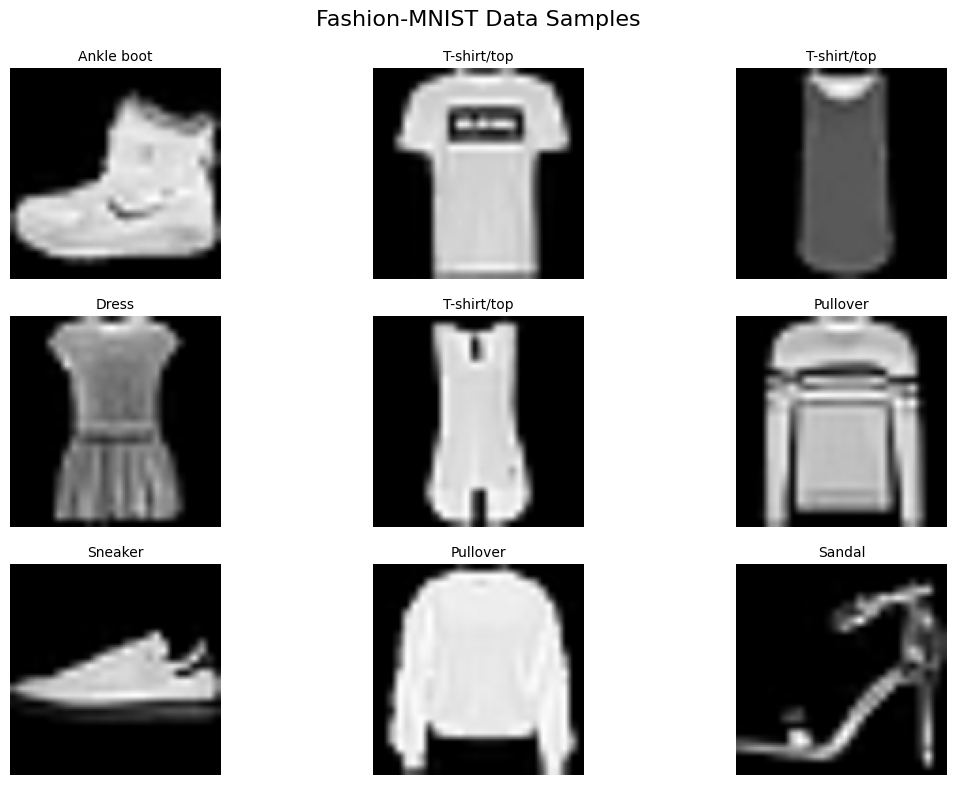

C:\Users\40428\AppData\Local\Temp\ipykernel_42104\1643769721.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Train subset size: 48000 samples
Validation subset size: 12000 samples
Test set size: 10000 samples

Starting transfer learning experiments...


Training MobileNetV2 model (trainable layers: 0)
MobileNetV2: Freezing all pretrained layers, training classifier only
Total 0 layers unfrozen for training
Trainable parameters: 12,810
Epoch 1/5
----------


Training:   0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\40428\AppData\Local\Temp\ipykernel_42104\1643769721.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████| 1500/1500 [00:17<00:00, 87.27it/s, batch_loss=0.368] 


Train Loss: 0.5929 Acc: 0.7955


Validation: 100%|██████████| 188/188 [00:04<00:00, 46.25it/s]


Val Loss: 0.4559 Acc: 0.8377
Epoch 2/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 98.93it/s, batch_loss=0.395] 


Train Loss: 0.4712 Acc: 0.8317


Validation: 100%|██████████| 188/188 [00:03<00:00, 47.70it/s]


Val Loss: 0.4307 Acc: 0.8428
Epoch 3/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 98.96it/s, batch_loss=0.602] 


Train Loss: 0.4579 Acc: 0.8353


Validation: 100%|██████████| 188/188 [00:03<00:00, 47.21it/s]


Val Loss: 0.3980 Acc: 0.8582
Epoch 4/5
----------


Training: 100%|██████████| 1500/1500 [00:14<00:00, 100.12it/s, batch_loss=0.505] 


Train Loss: 0.4478 Acc: 0.8396


Validation: 100%|██████████| 188/188 [00:03<00:00, 48.10it/s]


Val Loss: 0.4019 Acc: 0.8554
EarlyStopping counter: 1 out of 2
Epoch 5/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 99.87it/s, batch_loss=0.385] 


Train Loss: 0.4467 Acc: 0.8400


Validation: 100%|██████████| 188/188 [00:03<00:00, 48.42it/s]


Val Loss: 0.3909 Acc: 0.8586
Training completed in 1.62 minutes


Testing: 100%|██████████| 157/157 [00:03<00:00, 44.11it/s]


Test accuracy: 0.8582
Per-class accuracies:
  T-shirt/top: 0.8020
  Trouser: 0.9760
  Pullover: 0.7510
  Dress: 0.8540
  Coat: 0.7850
  Sandal: 0.9540
  Shirt: 0.6250
  Sneaker: 0.9150
  Bag: 0.9760
  Ankle boot: 0.9440


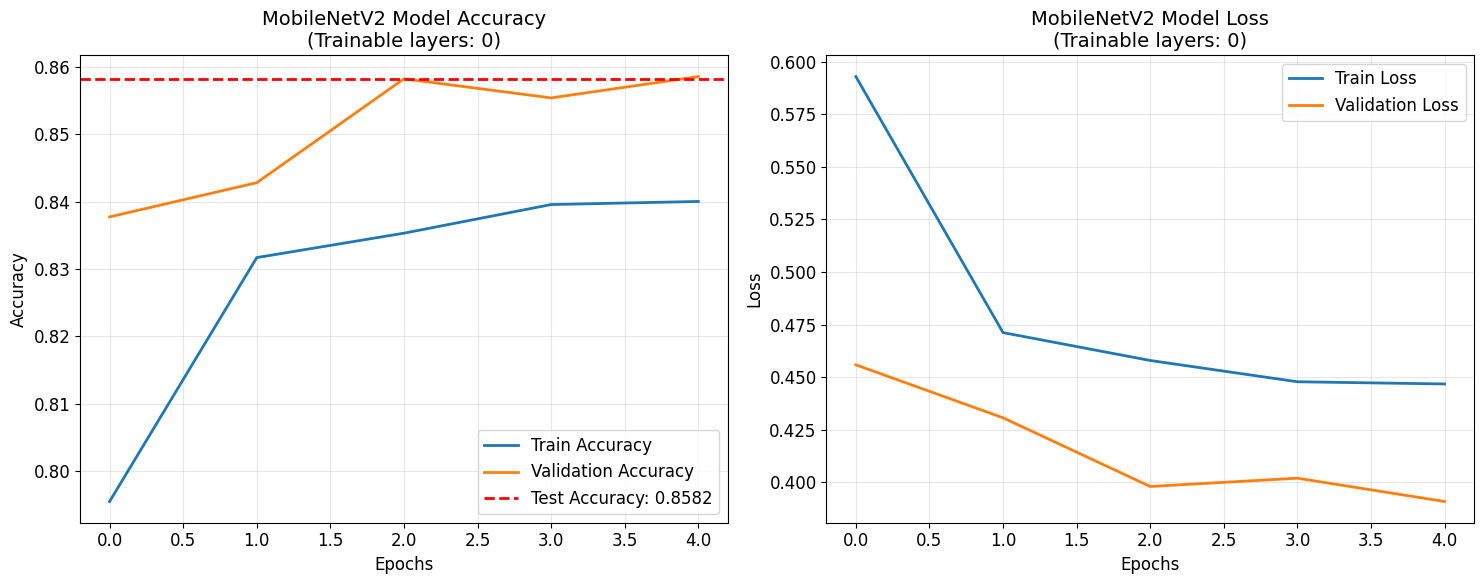

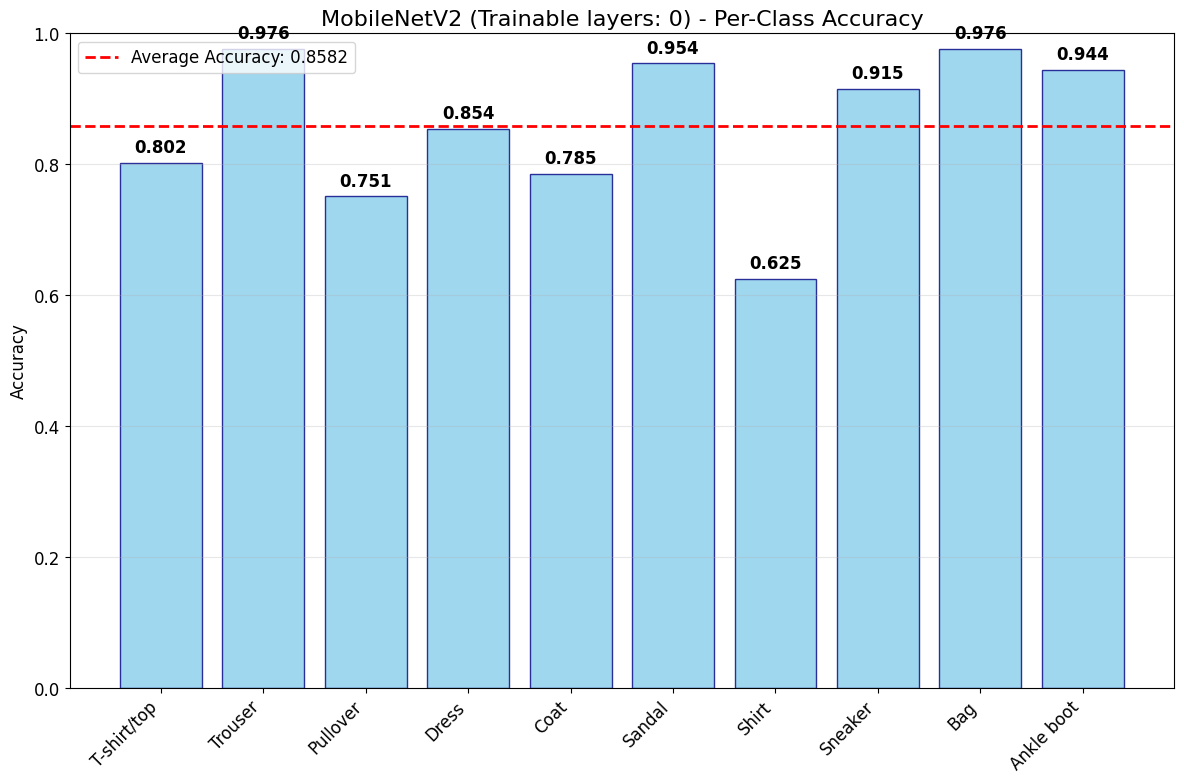


Training MobileNetV2 model (trainable layers: 5)
MobileNetV2: Unfreezing last 5 layers for fine-tuning, total 158 layers
Total 5 layers unfrozen for training
Trainable parameters: 424,970
Epoch 1/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 94.35it/s, batch_loss=0.488]  


Train Loss: 0.4701 Acc: 0.8306


Validation: 100%|██████████| 188/188 [00:03<00:00, 48.56it/s]


Val Loss: 0.3781 Acc: 0.8648
Epoch 2/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 96.34it/s, batch_loss=0.308]  


Train Loss: 0.3616 Acc: 0.8673


Validation: 100%|██████████| 188/188 [00:03<00:00, 47.62it/s]


Val Loss: 0.3339 Acc: 0.8789
Epoch 3/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 94.82it/s, batch_loss=0.491]  


Train Loss: 0.3254 Acc: 0.8808


Validation: 100%|██████████| 188/188 [00:04<00:00, 47.00it/s]


Val Loss: 0.3327 Acc: 0.8800
Epoch 4/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 95.88it/s, batch_loss=0.282]  


Train Loss: 0.2948 Acc: 0.8919


Validation: 100%|██████████| 188/188 [00:03<00:00, 48.95it/s]


Val Loss: 0.3321 Acc: 0.8803
Epoch 5/5
----------


Training: 100%|██████████| 1500/1500 [00:15<00:00, 95.63it/s, batch_loss=0.435]  


Train Loss: 0.2727 Acc: 0.9006


Validation: 100%|██████████| 188/188 [00:04<00:00, 46.99it/s]


Val Loss: 0.3152 Acc: 0.8882
Training completed in 1.64 minutes


Testing: 100%|██████████| 157/157 [00:03<00:00, 45.08it/s]


Test accuracy: 0.8870
Per-class accuracies:
  T-shirt/top: 0.8730
  Trouser: 0.9730
  Pullover: 0.8610
  Dress: 0.8950
  Coat: 0.8020
  Sandal: 0.9360
  Shirt: 0.6320
  Sneaker: 0.9690
  Bag: 0.9810
  Ankle boot: 0.9480


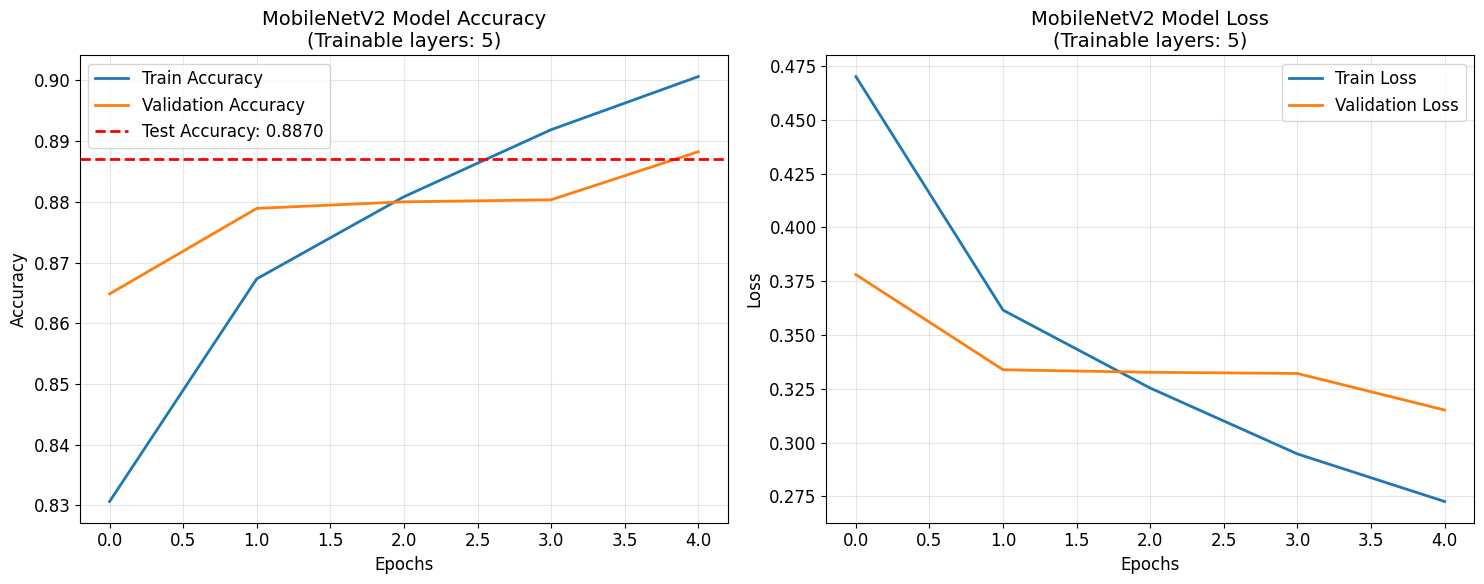

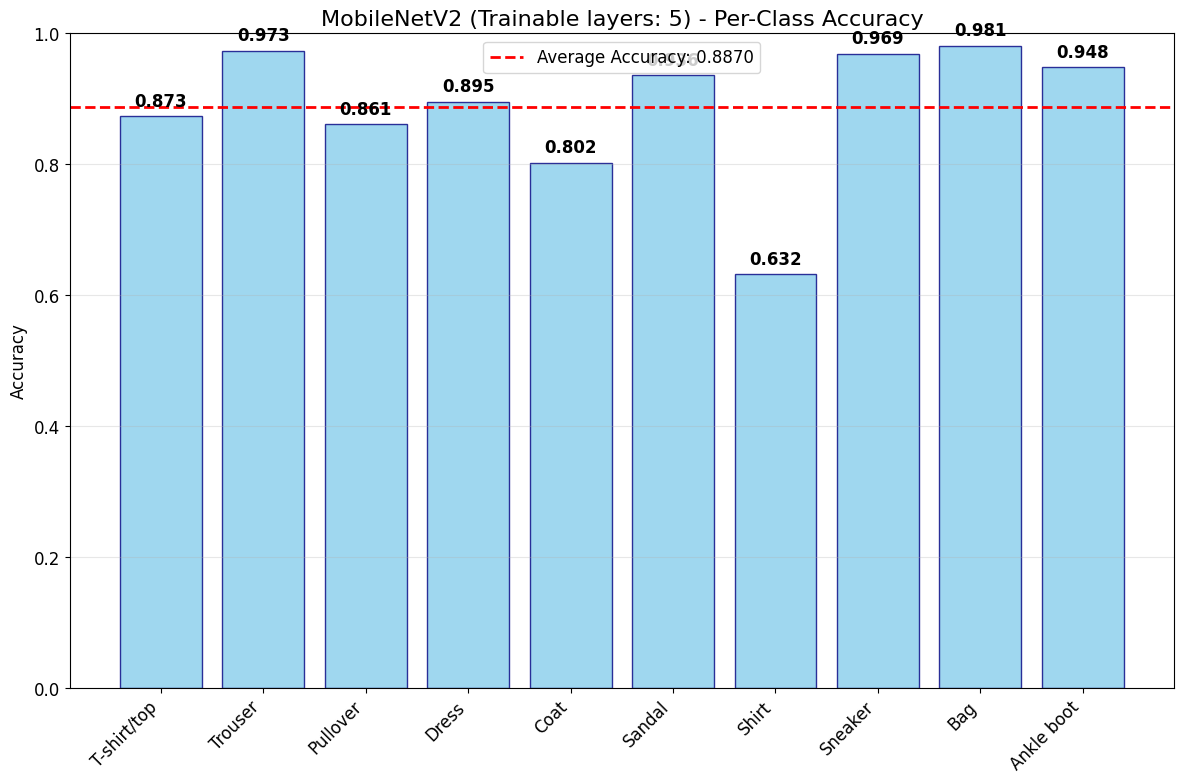


Training ResNet50 model (trainable layers: 0)
ResNet50: Freezing all pretrained layers, training classifier only
Total 0 layers unfrozen for training
Trainable parameters: 20,490
Epoch 1/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.91it/s, batch_loss=0.345] 


Train Loss: 0.6048 Acc: 0.7910


Validation: 100%|██████████| 188/188 [00:07<00:00, 23.78it/s]


Val Loss: 0.4592 Acc: 0.8366
Epoch 2/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.36it/s, batch_loss=0.33]  


Train Loss: 0.4816 Acc: 0.8289


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.12it/s]


Val Loss: 0.4405 Acc: 0.8447
Epoch 3/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.89it/s, batch_loss=0.663]  


Train Loss: 0.4519 Acc: 0.8386


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.06it/s]


Val Loss: 0.4515 Acc: 0.8381
EarlyStopping counter: 1 out of 2
Epoch 4/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 83.28it/s, batch_loss=0.318] 


Train Loss: 0.4337 Acc: 0.8441


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.05it/s]


Val Loss: 0.4254 Acc: 0.8502
Epoch 5/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.76it/s, batch_loss=0.566] 


Train Loss: 0.4269 Acc: 0.8464


Validation: 100%|██████████| 188/188 [00:07<00:00, 23.96it/s]


Val Loss: 0.4233 Acc: 0.8490
Training completed in 2.17 minutes


Testing: 100%|██████████| 157/157 [00:06<00:00, 22.79it/s]


Test accuracy: 0.8425
Per-class accuracies:
  T-shirt/top: 0.8490
  Trouser: 0.9610
  Pullover: 0.7720
  Dress: 0.8270
  Coat: 0.8450
  Sandal: 0.9340
  Shirt: 0.4280
  Sneaker: 0.8780
  Bag: 0.9690
  Ankle boot: 0.9620


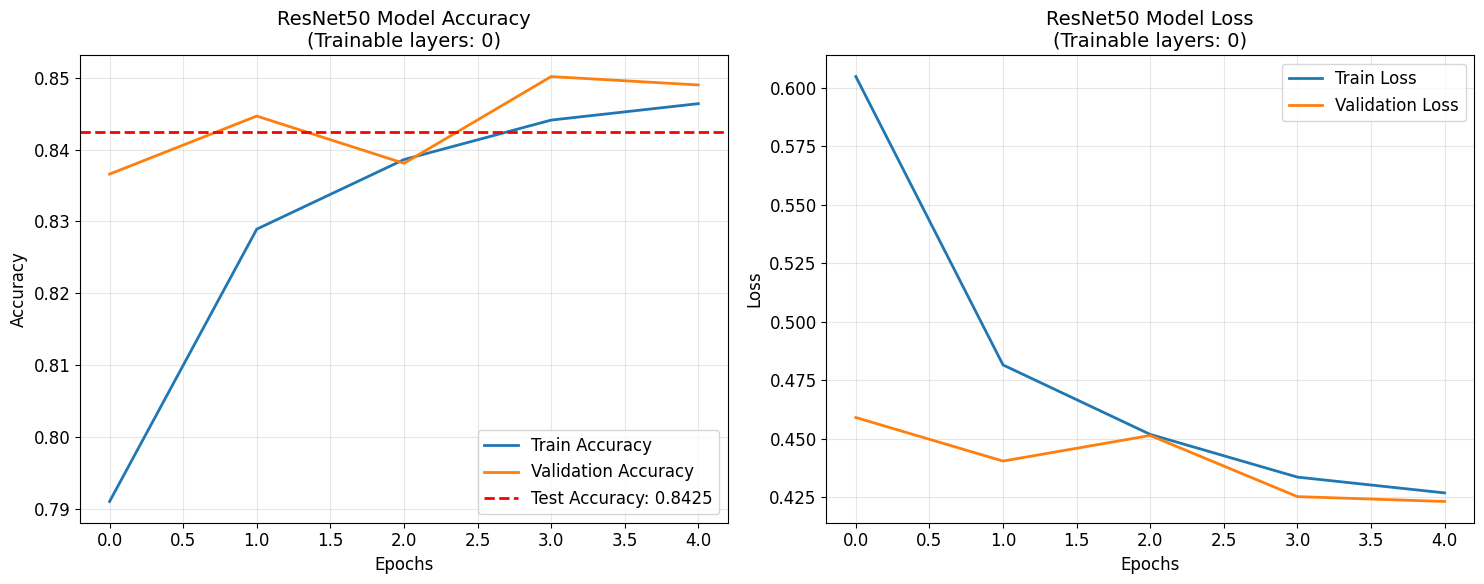

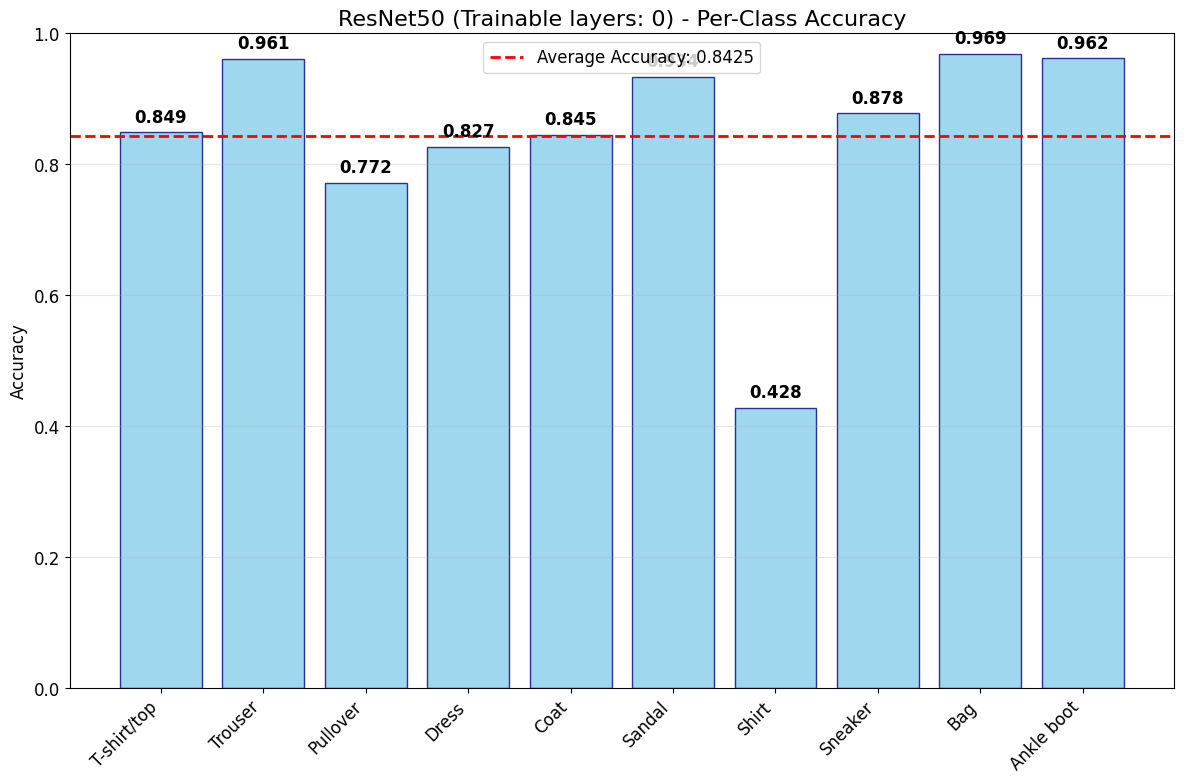


Training ResNet50 model (trainable layers: 5)
ResNet50: Unfreezing last 5 layers for fine-tuning, total 161 layers
Total 5 layers unfrozen for training
Trainable parameters: 1,073,162
Epoch 1/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.13it/s, batch_loss=0.495] 


Train Loss: 0.5475 Acc: 0.8043


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.08it/s]


Val Loss: 0.4525 Acc: 0.8353
Epoch 2/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.27it/s, batch_loss=0.433] 


Train Loss: 0.4254 Acc: 0.8450


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.22it/s]


Val Loss: 0.4215 Acc: 0.8488
Epoch 3/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.32it/s, batch_loss=0.427]  


Train Loss: 0.3823 Acc: 0.8595


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.11it/s]


Val Loss: 0.4078 Acc: 0.8505
Epoch 4/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 82.04it/s, batch_loss=0.447]  


Train Loss: 0.3405 Acc: 0.8747


Validation: 100%|██████████| 188/188 [00:07<00:00, 24.10it/s]


Val Loss: 0.3878 Acc: 0.8587
Epoch 5/5
----------


Training: 100%|██████████| 1500/1500 [00:18<00:00, 81.11it/s, batch_loss=0.135] 


Train Loss: 0.3091 Acc: 0.8861


Validation: 100%|██████████| 188/188 [00:07<00:00, 23.68it/s]


Val Loss: 0.3749 Acc: 0.8654
Training completed in 2.18 minutes


Testing: 100%|██████████| 157/157 [00:06<00:00, 22.51it/s]


Test accuracy: 0.8656
Per-class accuracies:
  T-shirt/top: 0.8180
  Trouser: 0.9660
  Pullover: 0.7620
  Dress: 0.8470
  Coat: 0.8360
  Sandal: 0.9770
  Shirt: 0.6530
  Sneaker: 0.9000
  Bag: 0.9630
  Ankle boot: 0.9340


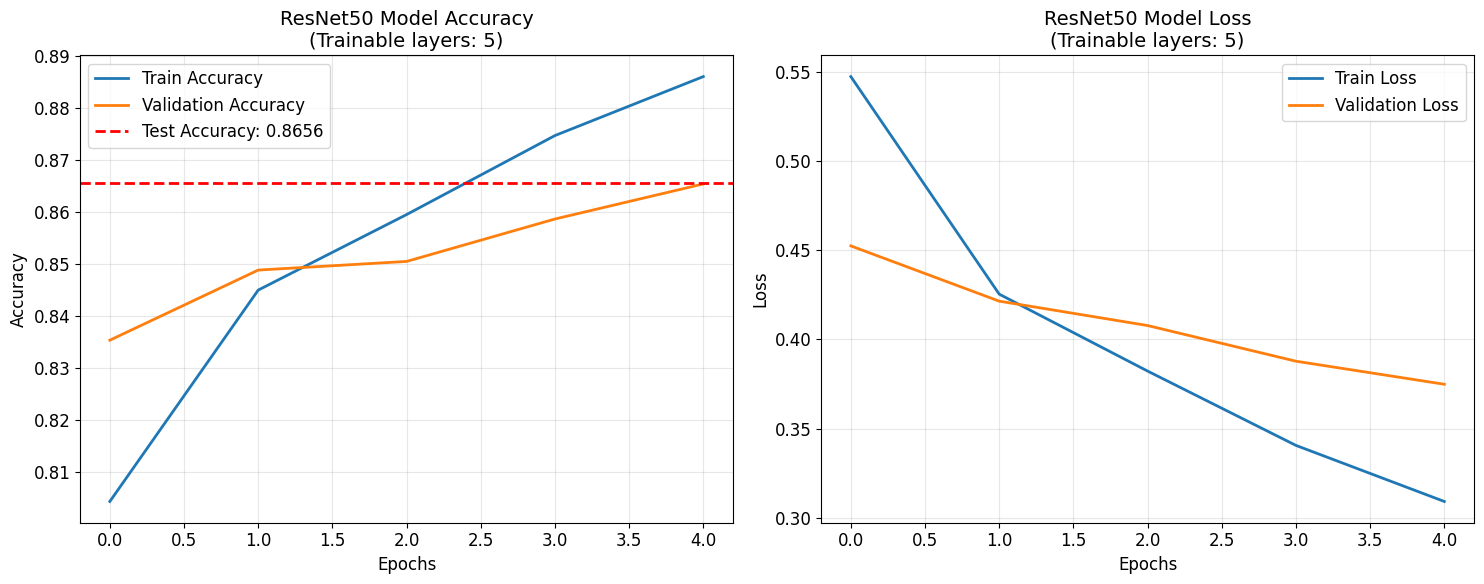

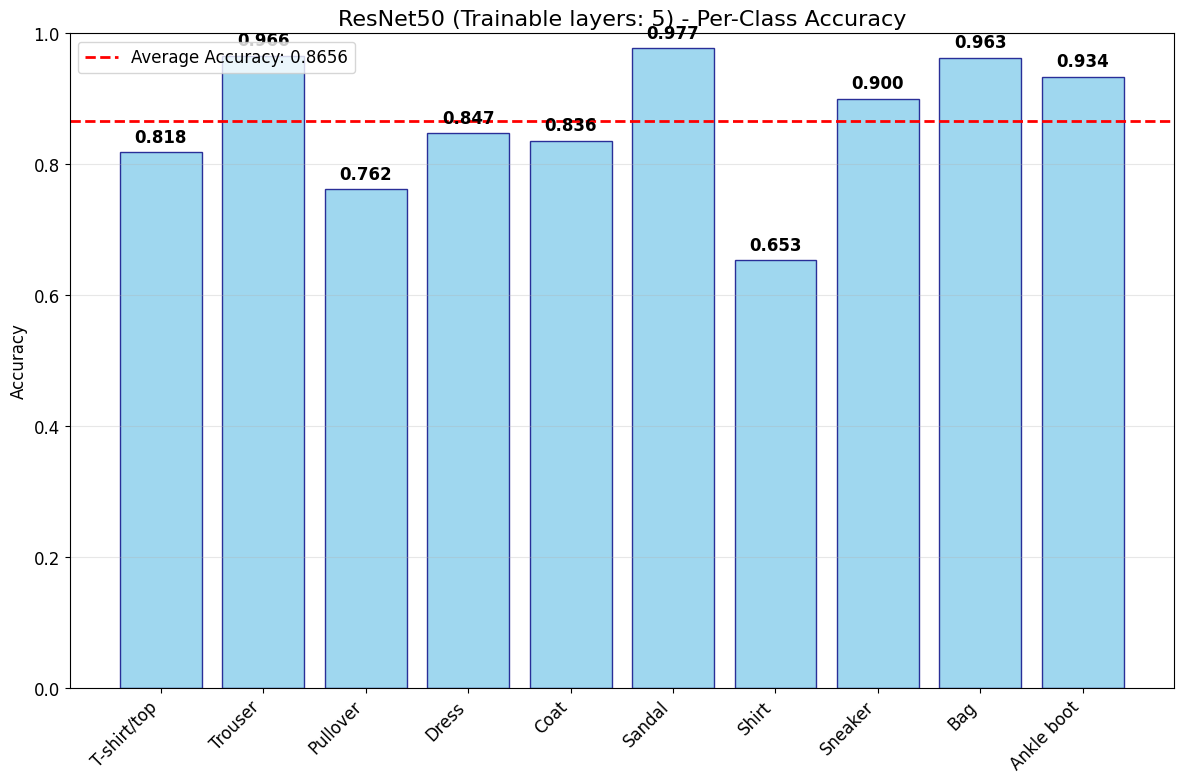

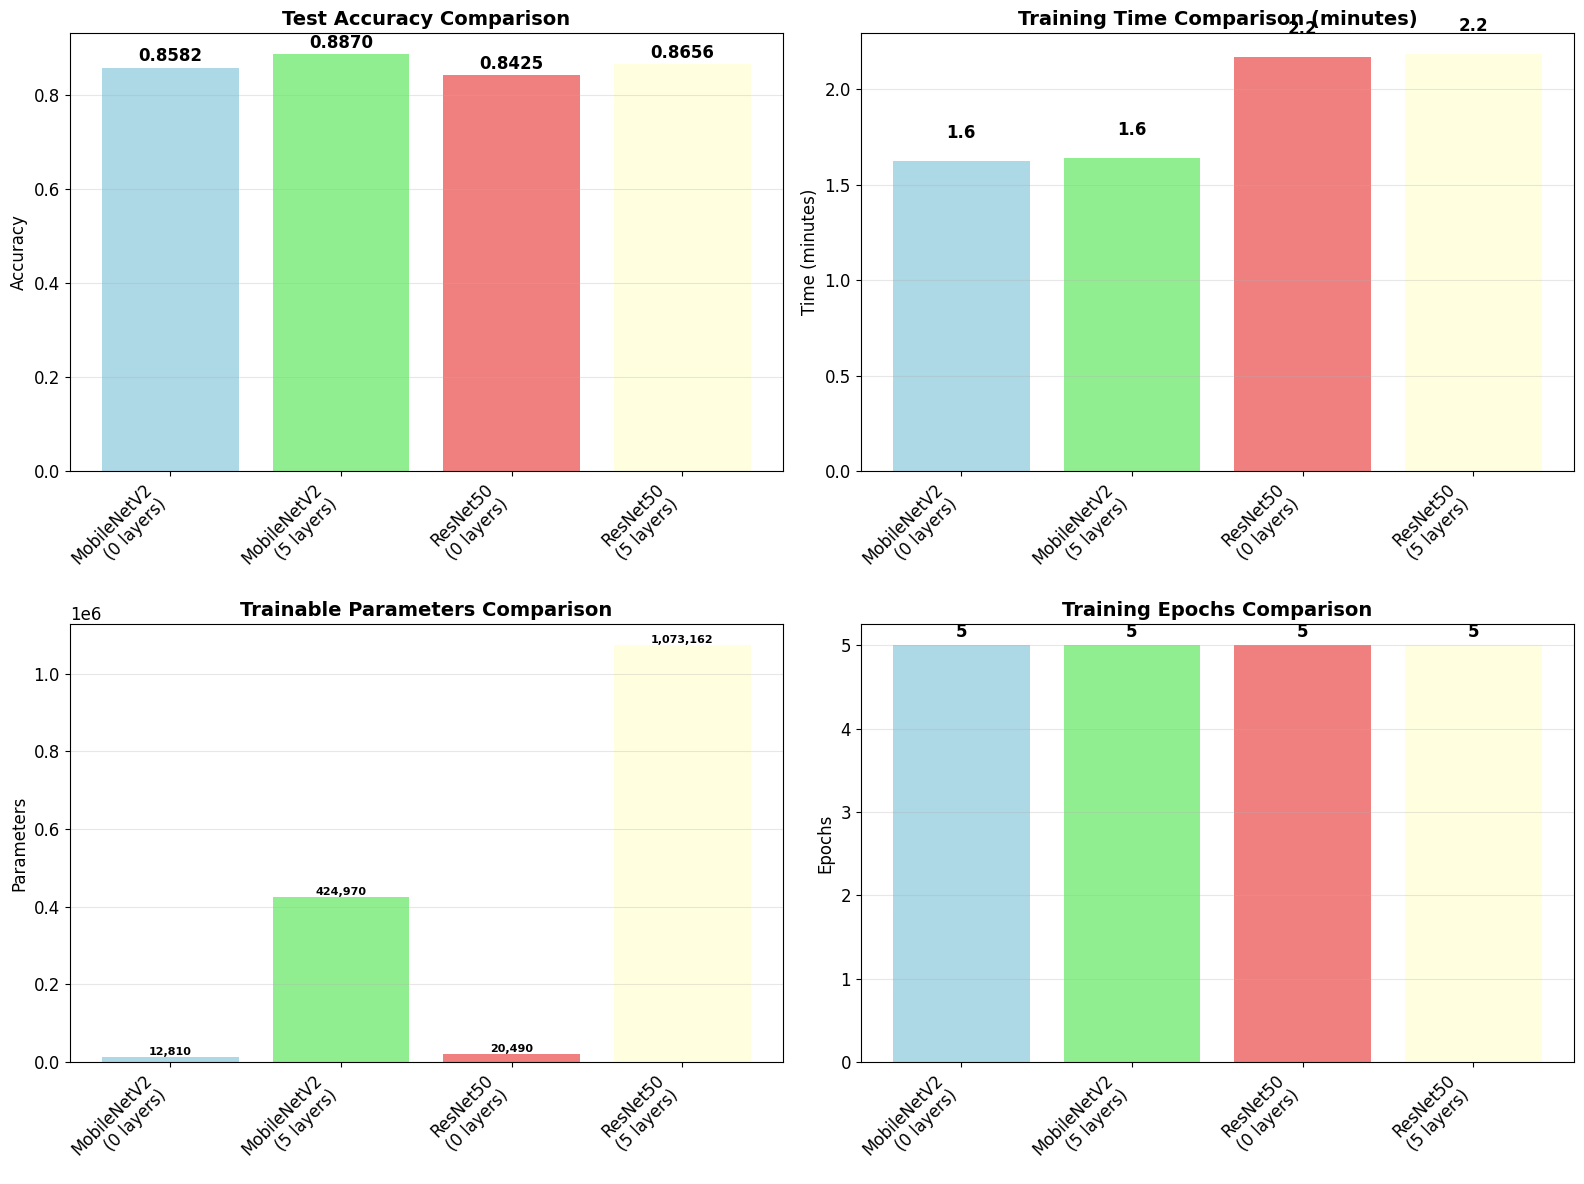


Experiment results summary:
MobileNetV2 (0 layers): Accuracy = 0.8582, Time = 1.6min, Params = 12,810
MobileNetV2 (5 layers): Accuracy = 0.8870, Time = 1.6min, Params = 424,970
ResNet50 (0 layers): Accuracy = 0.8425, Time = 2.2min, Params = 20,490
ResNet50 (5 layers): Accuracy = 0.8656, Time = 2.2min, Params = 1,073,162

Transfer learning experiments completed. Results saved to 'results' directory.


In [20]:
def main():
    """Main function to run the complete transfer learning experiment"""
    # Setup environment
    setup_environment()
    
    # Initialize experiment
    experiment = TransferLearningExperiment()
    
    # Setup data
    experiment.setup_data()
    
    print("\nStarting transfer learning experiments...\n")
    
    # Run experiments for different model configurations
    
    # MobileNetV2 - Feature extraction (frozen pretrained layers)
    experiment.run_experiment(MobileNetTransferLearning, 'MobileNetV2', 0)
    
    # MobileNetV2 - Fine-tuning (unfreeze last 5 layers)
    experiment.run_experiment(MobileNetTransferLearning, 'MobileNetV2', 5)
    
    # ResNet50 - Feature extraction (frozen pretrained layers)
    experiment.run_experiment(ResNet50TransferLearning, 'ResNet50', 0)
    
    # ResNet50 - Fine-tuning (unfreeze last 5 layers)
    experiment.run_experiment(ResNet50TransferLearning, 'ResNet50', 5)
    
    # Save all results
    experiment.save_results()
    
    print("\nTransfer learning experiments completed. Results saved to 'results' directory.")

# Quick test function for Jupyter
def quick_test():
    """Quick test with reduced epochs for Jupyter testing"""
    Config.NUM_EPOCHS = 2  # Reduce epochs for quick testing
    Config.BATCH_SIZE = 64  # Increase batch size for faster processing
    
    print("Running quick test with reduced epochs...")
    main()

if __name__ == "__main__":
    main()